## quick view picture

PIL mode: RGB
PIL mode: L


/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_9807/275598224.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


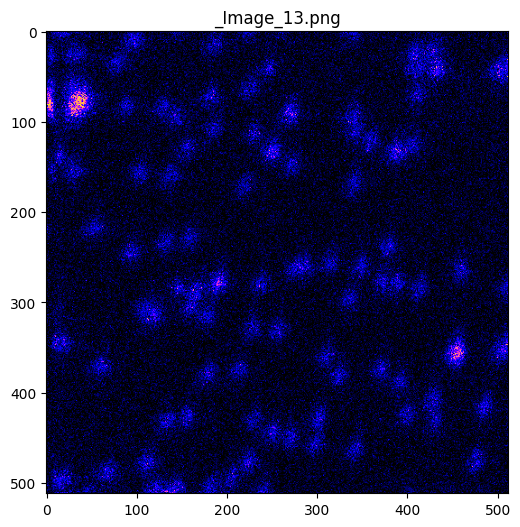

In [5]:
# open PNG image plot with matplotlib
fileDir = './4_data/trainning/200nm/'
fileName = '_Image_13.png'

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img = Image.open(fileDir + fileName)
print("PIL mode:", img.mode) # mode 屬性會告訴你色彩模式

img = img.convert('L')  # convert to grayscale
print("PIL mode:", img.mode)
img_array = np.array(img)
fig1, ax = plt.subplots(figsize=(8, 6))
ax.imshow(img_array, cmap='gnuplot2')
ax.set_title(fileName)
fig1.show()

## function view normed picture 

In [6]:
# norm with sqrt and plot center percent
from astropy.visualization import simple_norm

def plot_picture(data, percent, title: str, **kwargs):
    '''
    plot the fits file data
    img:
    get data by 
    hdu = fits.open('SLT_EPIC210651981.fits')
    data = hdu[0].data

    percent:
    only show middle {percent} percent data
    '''
    norm = simple_norm(data, stretch='sqrt', percent=percent)
    fig, ax = plt.subplots(**kwargs)  # 使用 subplots 來獲取圖形和軸對象
    img = ax.imshow(data, cmap='viridis', origin='lower', norm=norm, interpolation='nearest')
    fig.colorbar(img, ax=ax)  # 添加色條
    return fig, ax


### testing

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_9807/3025193716.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


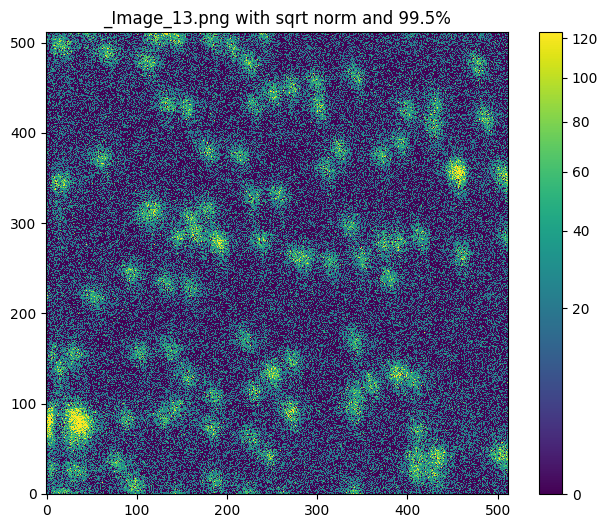

In [7]:

fig, ax = plot_picture(img_array, percent=99.5, title='Image_12.png', figsize=(8, 6))
ax.set_title(f'{fileName} with sqrt norm and 99.5%')
fig.show()

## background clean

In [8]:
def kappaSigmaClipping(kappa, iter, img_ori):
    '''
    do Kappa-Sigma Clipping, returm the mask in 2D array,
    True is pixel belong to background
    False is pixel belong to source
    img_ori: original image in 2D array
    kappa: kappa value, kappa * std will classify as source
    iter: iteration times
    '''
    img = img_ori
    mask = img > np.min(img) # create mask
    keep_pixel = img
    for i in range(iter):
        mean = np.mean(keep_pixel)
        std = np.std(keep_pixel)
        
        mask = img < mean + kappa*std
        keep_pixel = img[mask]
    bg_mean = np.mean(img[mask])
    bg_std = np.std(img[mask])
    return mask, bg_mean, bg_std

# bg_mean

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_9807/2684351129.py:8: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 1000 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  img_bg[~mask] = 1000  # set source pixel to bg_mean
/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_9807/2684351129.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


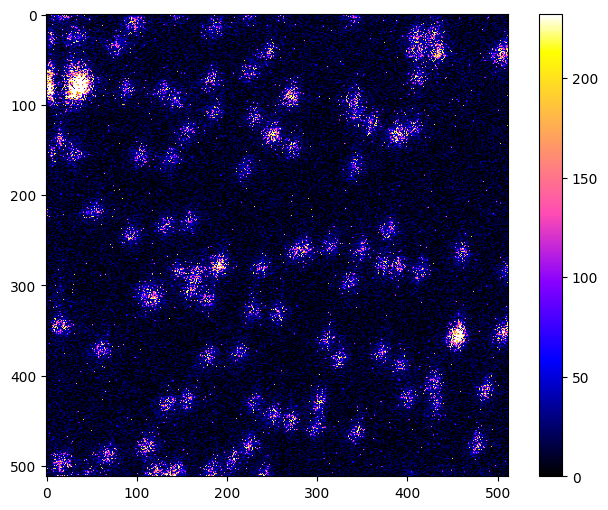

In [9]:
# viw the region that > bg_mean + kappa*std -> source
# let it be a great value to see it

mask, bg_mean, bg_std = kappaSigmaClipping(3, 20, img_array)
fig, ax = plt.subplots(figsize=(8, 6))

img_bg = np.copy(img_array)
img_bg[~mask] = 1000  # set source pixel to bg_mean
ax.imshow(img_bg, cmap='gnuplot2')
# colorbar
fig.colorbar(ax.imshow(img_bg, cmap='gnuplot2'), ax=ax)
fig.show()


### testing

In [10]:
mask, bg_mean, bg_std = kappaSigmaClipping(3, 7, img_array)

image_clean_bg = img_array - bg_mean
image_clean_bg[image_clean_bg < 0] = 0

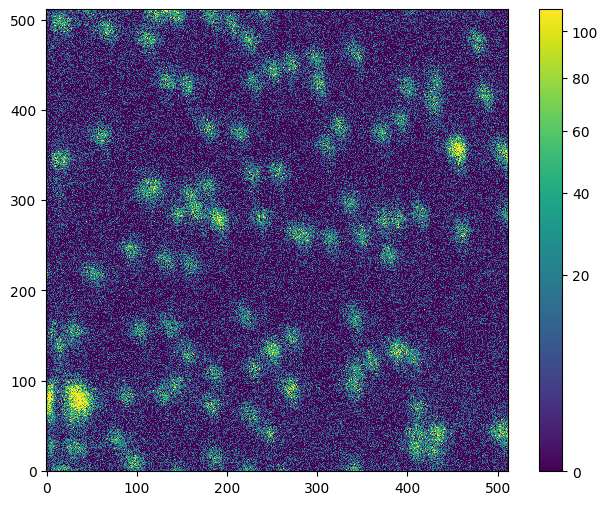

In [11]:
fig, ax = plot_picture(image_clean_bg, percent=99.5, title='Image_12.png', figsize=(8, 6))

## source detection

In [12]:
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats 
import scipy

def find_source(data, sigma=100.0, fwhm=7.0, threshold_times=5.):
    mean, median, std = sigma_clipped_stats(data, sigma=sigma) 
    daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold_times*std)  
    sources = daofind(data - median)  
    for col in sources.colnames:  
        if col not in ('id', 'npix'):
            sources[col].info.format = '%.2f'  # for consistent table output
    return sources

## plot source by circle

In [13]:
from photutils.aperture import CircularAperture

def plot_source(data, sources, **kwargs):
    '''
    return fig, ax
    '''
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    apertures = CircularAperture(positions, r=10.0)
    norm = simple_norm(data, stretch='sqrt', percent=99)

    fig, ax = plt.subplots(**kwargs)  # 使用 subplots 來獲取圖形和軸對象
    img = ax.imshow(data, cmap='viridis', origin='lower', norm=norm, interpolation='nearest')
    apertures.plot(color='white', lw=2, alpha=0.9, ax=ax)
    fig.colorbar(img, ax=ax)  # 添加色條

    # 返回圖形和軸對象
    return fig, ax

### testing

source number:  42


Text(0.5, 1.0, '_Image_13.png with sources')

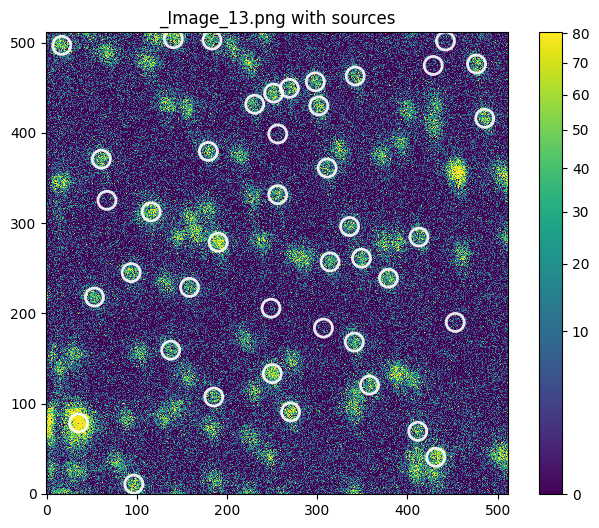

In [14]:
source = find_source(image_clean_bg, sigma=3.0, fwhm=30.0, threshold_times=5.)
print("source number: ", len(source))
# plot sources
fig_s, ax_s = plot_source(image_clean_bg, source, figsize=(8, 6))
ax_s.set_title(f'{fileName} with sources')

In [15]:
source

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,96.66,10.72,0.50,-0.30,-0.17,1521,0.00,41.30,27.38,-3.59
2,431.30,40.47,0.31,0.40,0.15,1521,0.00,41.30,28.76,-3.65
3,411.41,69.30,0.33,-0.06,0.31,1521,0.00,23.30,17.10,-3.08
4,35.45,78.55,0.52,-0.35,0.36,1521,0.00,169.30,98.21,-4.98
5,270.42,90.75,0.61,-0.10,0.29,1521,0.00,59.30,34.38,-3.84
6,185.32,107.25,0.98,-0.29,0.22,1521,0.00,41.30,15.72,-2.99
7,357.90,120.45,0.27,0.39,0.20,1521,0.00,23.30,16.24,-3.03
8,250.20,133.23,0.59,0.27,0.17,1521,0.00,59.30,34.24,-3.84
9,137.58,159.15,0.37,-0.34,0.11,1521,0.00,23.30,16.21,-3.02


## calculate fwhm

In [43]:
from astropy.modeling import models, fitting

def FWHM2d(Qtable, data, sub_size_half=6):
    '''
    return fwhm_x_list, fwhm_y_list, mask
    mask is a boolen vector, if star distance to image margin
    smaller then sub_size_half, mask value will be false
    '''
    fwhm_x_list = []
    fwhm_y_list = []
    mask = []
    for i in range(len(Qtable)):
        xc, yc = Qtable['xcentroid'][i], Qtable['ycentroid'][i]  

        # 如果需要，选取一个子区域进行拟合
        # 例如，取以 (x, y) 为中心的 12 x 12 像素区域
        x_min, x_max = int(xc - sub_size_half), int(xc + sub_size_half)
        y_min, y_max = int(yc - sub_size_half), int(yc + sub_size_half)
        # print(x_min, x_max, y_min, y_max)
        if x_min < 0 or x_max < 0 or y_min < 0 or y_max < 0:
            fwhm_x_list.append(-1)
            fwhm_y_list.append(-1)
            mask.append(False)
            continue
        mask.append(True)
        sub_data = data[y_min:y_max, x_min:x_max]
        yp, xp = sub_data.shape


        # Generate grid of same size like box to put the fit on
        y, x, = np.mgrid[:yp, :xp]
        # Declare what function you want to fit to your data
        f_init = models.Gaussian2D()
        # Declare what fitting function you want to use
        fit_f = fitting.LevMarLSQFitter()

        # Fit the model to your data (box)
        fitted_g = fit_f(f_init, x, y, sub_data)


        # print(dir(fitted_g))           # 列出所有屬性和方法
        print(fitted_g.parameters)     # 列出所有參數名稱
        print(fitted_g.__dict__)       # 列出所有屬性和值
        # 计算 FWHM
        fwhm_x = 2.355 * fitted_g.x_stddev.value
        fwhm_y = 2.355 * fitted_g.y_stddev.value

        fwhm_x_list.append(fwhm_x)
        fwhm_y_list.append(fwhm_y)
        # plot_2d_gaussian_profile(sub_data, fitted_g)

    return fwhm_x_list, fwhm_y_list, mask

In [ ]:
# def plot_2d_gaussian_profile():
#     yp, xp = sub_data.shape
#     y, x = np.mgrid[:yp, :xp]
#     # 中心點
#     x0, y0 = fitted_g.x_mean.value, fitted_g.y_mean.value
#     # 計算 r
#     r = np.sqrt((x - x0)**2 + (y - y0)**2)
#     intensity = sub_data.flatten()
#     r_flat = r.flatten()
#     # 按 r 分 bin 平均
#     from scipy.stats import binned_statistic
#     bins = np.linspace(0, r_flat.max(), 50)
#     mean_intensity, _, _ = binned_statistic(r_flat, intensity, statistic='mean', bins=bins)
#     bin_centers = (bins[:-1] + bins[1:]) / 2

#     plt.figure(figsize=(6,4))
#     plt.plot(bin_centers, mean_intensity, 'g.', label='Data (binned)')
#     # 理論 2D Gaussian 曲線
#     amp = fitted_g.amplitude.value
#     sigma = (fitted_g.x_stddev.value + fitted_g.y_stddev.value) / 2
#     plt.plot(bin_centers, amp * np.exp(-bin_centers**2 / (2 * sigma**2)), 'k--', label='2D Gaussian fit')
#     plt.xlabel('r (pixels)')
#     plt.ylabel('Intensity')
#     plt.legend()
#     plt.title('Radial Profile of 2D Gaussian Fit')
#     plt.show()

### testing

In [44]:
x_fwhm, y_fwhm, mask = FWHM2d(source, image_clean_bg, sub_size_half=12)
source['x_fwhm'] = x_fwhm
source['y_fwhm'] = y_fwhm
source = source[mask]
source

[57.51845692 13.1214446  12.98390438  8.01833872 10.69661821 -0.1744705 ]
{'_inputs': ('x', 'y'), '_outputs': ('z',), '_name': None, 'amplitude': Parameter('amplitude', value=57.51845691727707), 'x_mean': Parameter('x_mean', value=13.121444604861432), 'y_mean': Parameter('y_mean', value=12.983904380486637), 'x_stddev': Parameter('x_stddev', value=8.018338720220237, bounds=(1.1754943508222875e-38, None)), 'y_stddev': Parameter('y_stddev', value=10.696618210366452, bounds=(1.1754943508222875e-38, None)), 'theta': Parameter('theta', value=-0.17447050313158302), '_mconstraints': {'eqcons': [], 'ineqcons': []}, '_model_set_axis': False, '_param_metrics': defaultdict(<class 'dict'>, {'amplitude': {'slice': slice(0, 1, None), 'shape': (), 'size': 1}, 'x_mean': {'slice': slice(1, 2, None), 'shape': (), 'size': 1}, 'y_mean': {'slice': slice(2, 3, None), 'shape': (), 'size': 1}, 'x_stddev': {'slice': slice(3, 4, None), 'shape': (), 'size': 1}, 'y_stddev': {'slice': slice(4, 5, None), 'shape': ()

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,x_fwhm,y_fwhm
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64
2,431.30,40.47,0.31,0.40,0.15,1521,0.00,41.30,28.76,-3.65,18.88318768611866,25.190535885412995
3,411.41,69.30,0.33,-0.06,0.31,1521,0.00,23.30,17.10,-3.08,16.90304558783479,21.181260630865303
4,35.45,78.55,0.52,-0.35,0.36,1521,0.00,169.30,98.21,-4.98,26.757555393246076,19.301610239254117
5,270.42,90.75,0.61,-0.10,0.29,1521,0.00,59.30,34.38,-3.84,15.125629196617513,19.103502006149785
6,185.32,107.25,0.98,-0.29,0.22,1521,0.00,41.30,15.72,-2.99,19.14017631301021,16.787265656503816
7,357.90,120.45,0.27,0.39,0.20,1521,0.00,23.30,16.24,-3.03,27.076858032183818,23.241439599446032
8,250.20,133.23,0.59,0.27,0.17,1521,0.00,59.30,34.24,-3.84,15.56081556798062,17.853209331363256
9,137.58,159.15,0.37,-0.34,0.11,1521,0.00,23.30,16.21,-3.02,21.99521682333165,18.588976272828646
10,341.06,168.18,0.36,-0.35,0.50,1521,0.00,23.30,16.73,-3.06,14.368608101561003,24.567910720848783


## plot source elipse

In [19]:
from photutils.aperture import EllipticalAperture

def plot_source_fwhm_elips(data, sources, **kwargs):
    apertures = []
    for source in sources:
        position = (source['xcentroid'], source['ycentroid'])
        a = source['x_fwhm']  # x軸半徑
        b = source['y_fwhm']  # y軸半徑
        theta = 0  # 橢圓角度（如有可用 source['theta']）
        aperture = EllipticalAperture(position, a=a, b=b, theta=theta)
        apertures.append(aperture)

    norm = simple_norm(data, stretch='sqrt', percent=99)
    fig, ax = plt.subplots(**kwargs)
    img = ax.imshow(data, cmap='viridis', origin='lower', norm=norm, interpolation='nearest')
    fig.colorbar(img, ax=ax)
    for aperture in apertures:
        aperture.plot(color='white', lw=1.5, alpha=0.9, ax=ax)
    return fig, ax


### testing

Text(0.5, 1.0, '_Image_13.png with FWHM elipse')

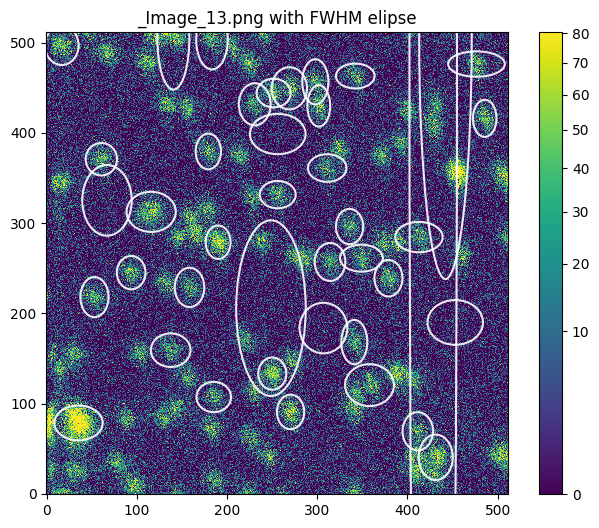

In [20]:
fig, ax = plot_source_fwhm_elips(image_clean_bg, source, figsize=(8, 6))
ax.set_title(f'{fileName} with FWHM elipse')



In [21]:
source

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,x_fwhm,y_fwhm
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64
2,431.30,40.47,0.31,0.40,0.15,1521,0.00,41.30,28.76,-3.65,18.88318768611866,25.190535885412995
3,411.41,69.30,0.33,-0.06,0.31,1521,0.00,23.30,17.10,-3.08,16.90304558783479,21.181260630865303
4,35.45,78.55,0.52,-0.35,0.36,1521,0.00,169.30,98.21,-4.98,26.757555393246076,19.301610239254117
5,270.42,90.75,0.61,-0.10,0.29,1521,0.00,59.30,34.38,-3.84,15.125629196617513,19.103502006149785
6,185.32,107.25,0.98,-0.29,0.22,1521,0.00,41.30,15.72,-2.99,19.14017631301021,16.787265656503816
7,357.90,120.45,0.27,0.39,0.20,1521,0.00,23.30,16.24,-3.03,27.076858032183818,23.241439599446032
8,250.20,133.23,0.59,0.27,0.17,1521,0.00,59.30,34.24,-3.84,15.56081556798062,17.853209331363256
9,137.58,159.15,0.37,-0.34,0.11,1521,0.00,23.30,16.21,-3.02,21.99521682333165,18.588976272828646
10,341.06,168.18,0.36,-0.35,0.50,1521,0.00,23.30,16.73,-3.06,14.368608101561003,24.567910720848783


## plot FWHM x y distribution

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_9807/1015418424.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


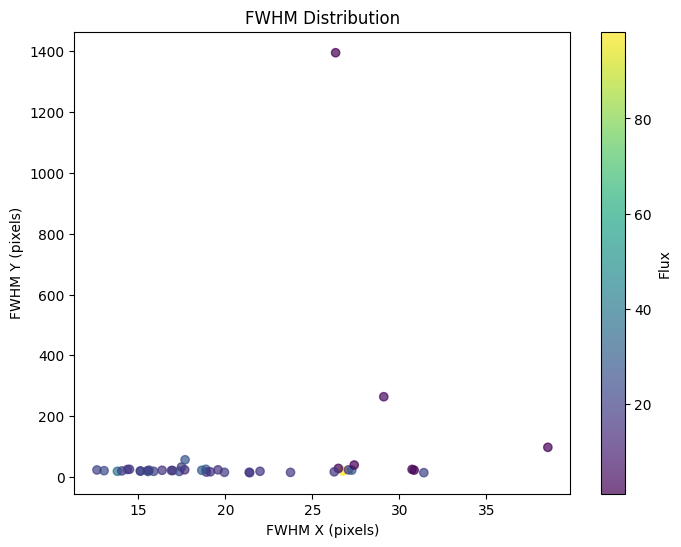

In [22]:
# plot the distribution of fwhm x y size dot plot
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(source['x_fwhm'], source['y_fwhm'], c=source['flux'], cmap='viridis', alpha=0.7)
fig.colorbar(sc, label='Flux')
ax.set_xlabel('FWHM X (pixels)')
ax.set_ylabel('FWHM Y (pixels)')
ax.set_title('FWHM Distribution')
fig.show()

In [23]:
# ignore fwhm > 40
threshold = 30
source = source[(source['x_fwhm'] < threshold) & (source['y_fwhm'] < threshold)]
len(source)

32

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_9807/1015418424.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


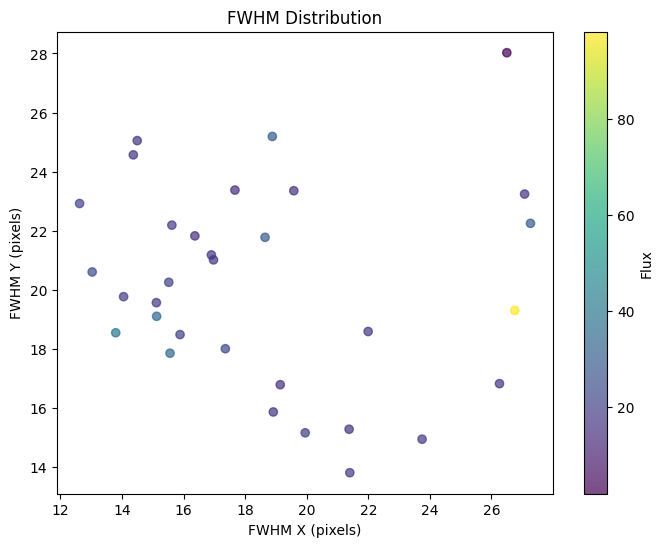

In [24]:
# plot the distribution of fwhm x y size dot plot
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(source['x_fwhm'], source['y_fwhm'], c=source['flux'], cmap='viridis', alpha=0.7)
fig.colorbar(sc, label='Flux')
ax.set_xlabel('FWHM X (pixels)')
ax.set_ylabel('FWHM Y (pixels)')
ax.set_title('FWHM Distribution')
fig.show()

Text(0.5, 1.0, '_Image_13.png with FWHM elipse')

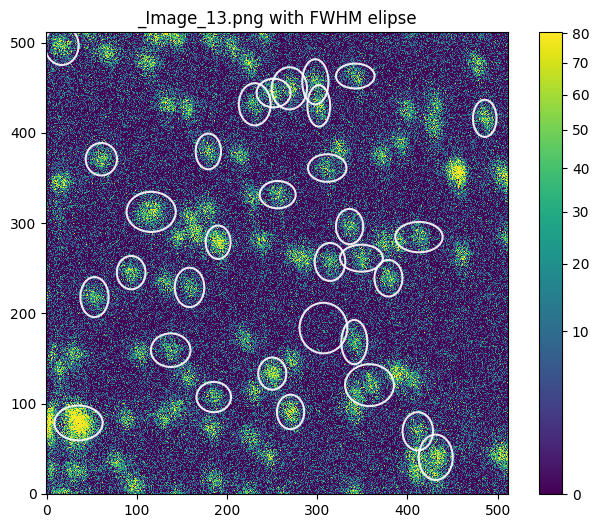

In [25]:
fig, ax = plot_source_fwhm_elips(image_clean_bg, source, figsize=(8, 6))
ax.set_title(f'{fileName} with FWHM elipse')

In [26]:
source[1]

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,x_fwhm,y_fwhm
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64
3,411.41,69.30,0.33,-0.06,0.31,1521,0.00,23.30,17.10,-3.08,16.90304558783479,21.181260630865303


## from source center,  draw a rectangle, fit gaussian. draw a line for x +- 2FWHMx, average y +- factor * FWHMy 

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

factor = 1 # factor for FWHM_y in plot_x_cut_gaussian

def gaussian(x, amp, mu, sigma, offset):
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2)) + offset


def fit_gaussian(image, sources, sourceID, factor=1):
    source = sources[sourceID]
    x0 = source['xcentroid']
    y0 = source['ycentroid']
    y_half_range = factor * source['y_fwhm']
    
    # 選擇 Y 範圍的像素索引
    y_min = int(max(0, y0 - y_half_range))
    y_max = int(min(image.shape[0], y0 + y_half_range + 1))
    # X 軸範圍 ± 2×FWHM
    x_min = int(max(0, x0 - 2*source['x_fwhm']))
    x_max = int(min(image.shape[1], x0 + 2*source['x_fwhm'] + 1))
    # 取出該範圍的截面
    cut_data = image[y_min:y_max, x_min:x_max]
    
    # Y 平均 → 一維強度分佈
    intensity_profile = np.mean(cut_data, axis=0)
    

    x_range = np.arange(x_min, x_max)
    x_rel_range = x_range - x0
    print("x relative range ", x_rel_range)
    
    # Gaussian 擬合
    # p0 = [ampliture, mean, sigma, offset] fitting initial guess
    p0 = [np.max(intensity_profile)-np.min(intensity_profile), 0, source['x_fwhm']/2.355, np.min(intensity_profile)]
    parm, _ = curve_fit(gaussian, x_rel_range, intensity_profile, p0=p0)
    
    return parm, x_rel_range, intensity_profile, x0, y_half_range



## fit_gaussian_xy

In [28]:
import numpy as np
from typing import Literal
from scipy.optimize import curve_fit

def fit_gaussian_xy(image, sources, sourceID, axis: Literal['x', 'y'], factor=1):
    source = sources[sourceID]
    if axis == 'x':
        # x profile: x ± 2FWHMx, y ± factor*FWHMy
        x0 = source['xcentroid']
        y0 = source['ycentroid']
        x_fwhm = source['x_fwhm']
        y_fwhm = source['y_fwhm']
        y_half_range = factor * y_fwhm
        y_min = int(max(0, y0 - y_half_range))
        y_max = int(min(image.shape[0], y0 + y_half_range + 1))
        x_min = int(max(0, x0 - 2*x_fwhm))
        x_max = int(min(image.shape[1], x0 + 2*x_fwhm + 1))
        cut_data = image[y_min:y_max, x_min:x_max]
        intensity_profile = np.mean(cut_data, axis=0)
        main_range = np.arange(x_min, x_max)
        main_rel_range = main_range - x0
        sigma_guess = x_fwhm / 2.355
    elif axis == 'y':
        # y profile: y ± 2FWHMy, x ± factor*FWHMx
        x0 = source['xcentroid']
        y0 = source['ycentroid']
        x_fwhm = source['x_fwhm']
        y_fwhm = source['y_fwhm']
        x_half_range = factor * x_fwhm
        x_min = int(max(0, x0 - x_half_range))
        x_max = int(min(image.shape[1], x0 + x_half_range + 1))
        y_min = int(max(0, y0 - 2*y_fwhm))
        y_max = int(min(image.shape[0], y0 + 2*y_fwhm + 1))
        cut_data = image[y_min:y_max, x_min:x_max]
        intensity_profile = np.mean(cut_data, axis=1)
        main_range = np.arange(y_min, y_max)
        main_rel_range = main_range - y0
        sigma_guess = y_fwhm / 2.355
    else:
        raise ValueError("axis must be 'x' or 'y'")

    p0 = [np.max(intensity_profile)-np.min(intensity_profile), 0, sigma_guess, np.min(intensity_profile)]
    from scipy.optimize import curve_fit
    parm, _ = curve_fit(gaussian, main_rel_range, intensity_profile, p0=p0)
    return parm, main_rel_range, intensity_profile, (x0 if axis=='x' else y0), (y_half_range if axis=='x' else x_half_range)

In [29]:
# def fit_gaussian2(image, sources, sourceID, axis, factor=1):
#     '''
#     try to let it can fit x and y
#     axis = x or y
#     '''
#     x_label = ('xcentriod', 'x_fwhm')
#     y_label = ('ycentroid', 'y_fwhm')

#     if axis == 'x':
#         horizontal_label = x_label
#         vertical_label = y_label
#     if axis == 'y':
#         horizontal_label = y_label
#         vertical_label = x_label
#     else:
#         print("axis should br x or y")

#     source = sources[sourceID]
#     x0 = source[horizontal_label[0]]
#     y0 = source[vertical_label[0]]
#     y_half_range = factor * source[vertical_label[1]]
    
#     # 選擇 Y 範圍的像素索引
#     y_min = int(max(0, y0 - y_half_range))
#     y_max = int(min(image.shape[0], y0 + y_half_range + 1))
#     # X 軸範圍 ± 2×FWHM
#     x_min = int(max(0, x0 - 2*source[horizontal_label[1]]))
#     x_max = int(min(image.shape[1], x0 + 2*source[horizontal_label[1]] + 1))
#     # 取出該範圍的截面
#     cut_data = image[y_min:y_max, x_min:x_max]
    
#     # Y 平均 → 一維強度分佈
#     intensity_profile = np.mean(cut_data, axis=0)
    

#     x_range = np.arange(x_min, x_max)
#     x_rel_range = x_range - x0
    
#     # Gaussian 擬合
#     p0 = [np.max(intensity_profile)-np.min(intensity_profile), 0, source[horizontal_label[1]]/2.355, np.min(intensity_profile)]
#     parm, _ = curve_fit(gaussian, x_rel_range, intensity_profile, p0=p0)
    
#     return parm, x_rel_range, intensity_profile, x0, y_half_range

In [ ]:

factor = 1 # factor for FWHM_y in plot_x_cut_gaussian

def gaussian(x, amp, mu, sigma, offset):
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2)) + offset

def plot_x_cut_gaussian(image, sources, sourceID, factor=1, ax=None):
    '''
    plot the x cut +- 2 FWHMx, avg(+- factor * FWHMy) of the source and fit with gaussian
    '''
    if ax is None:
        figsize=(6,4)
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure # 表示外面傳進來的 ax，要交給外面管理

    source = sources[sourceID]
    parm, x_rel, intensity_profile, x0, y_half_range = fit_gaussian(image, sources, sourceID, axis='x', factor=factor)

    # 繪圖
    ax.plot(x_rel, intensity_profile, 'g.', label='Data')
    ax.plot(x_rel, gaussian(x_rel, *parm), 'k--', label='Gaussian fit')
    
    # 從擬合參數取出 mu, sigma
    amp, mu, sigma, offset = parm # mu 是中心, sigma 是標準差
    fwhm = 2.355 * sigma

    # 畫出中心線
    ax.axvline(mu, color='gray', linestyle='-', label='Fit center')

    # --- FWHM 標示區塊 ---
    amp, mu, sigma, offset = parm
    fwhm = 2.355 * sigma
    half_max = offset + amp / 2

    # 畫灰底矩形 (標示 FWHM 區域)
    ax.axvspan(mu - fwhm/2, mu + fwhm/2, 
               ymin=0,
               color='gray', alpha=0.2)
    # 雙箭頭顯示 FWHM
    ax.annotate(
        '', 
        xy=(mu + fwhm/2, half_max), 
        xytext=(mu - fwhm/2, half_max),
        arrowprops=dict(arrowstyle='<->', color='b', lw=1.5)
    )
    # 在箭頭下方加文字標籤
    ax.text(mu, half_max*0.7, f"FWHM = {fwhm:.2f}", 
            color='b', ha='center', va='bottom', fontsize=10)




    # 標示 Y 標準差
    # ax.errorbar(x_rel, intensity_profile, yerr=intensity_std, fmt='none',ecolor='g', label='Data ± 1σ', alpha=0.3)

    ax.set_xlabel('X distance from center [pixels]')
    ax.set_ylabel('Intensity')
    ax.set_title(
    f"ID:{sourceID} Cut at x = {int(x0)}, y ± {int(source['y_fwhm']*factor)} pixels\n"
    )
    ax.legend()
    
    return parm, ax


In [51]:
def plot_xy_cut_gaussian(image, sources, sourceID, axis:Literal['x', 'y'], factor=1, ax=None):
    '''
    plot the x cut +- 2 FWHMx, avg(+- factor * FWHMy) of the source and fit with gaussian
    '''
    assert axis in ('x', 'y'), "axis 只能是 'x' 或 'y'"
    if ax is None:
        figsize=(6,4)
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure # 表示外面傳進來的 ax，要交給外面管理

    source = sources[sourceID]
    parm, x_rel, intensity_profile, x0, y_half_range = fit_gaussian(image, sources, sourceID,factor=factor)

    # 繪圖
    ax.plot(x_rel, intensity_profile, 'g.', label='Data')
    ax.plot(x_rel, gaussian(x_rel, *parm), 'k--', label='Gaussian fit')
    
    # 從擬合參數取出 mu, sigma
    amp, mu, sigma, offset = parm # mu 是中心, sigma 是標準差
    fwhm = 2.355 * sigma

    # 畫出中心線
    ax.axvline(mu, color='gray', linestyle='-', label='Fit center')

    # --- FWHM 標示區塊 ---
    amp, mu, sigma, offset = parm
    fwhm = 2.355 * sigma
    half_max = offset + amp / 2

    # 畫灰底矩形 (標示 FWHM 區域)
    ax.axvspan(mu - fwhm/2, mu + fwhm/2, 
               ymin=0,
               color='gray', alpha=0.2)
    # 雙箭頭顯示 FWHM
    ax.annotate(
        '', 
        xy=(mu + fwhm/2, half_max), 
        xytext=(mu - fwhm/2, half_max),
        arrowprops=dict(arrowstyle='<->', color='b', lw=1.5)
    )
    # 在箭頭下方加文字標籤
    ax.text(mu, half_max*0.7, f"FWHM = {fwhm:.2f}", 
            color='b', ha='center', va='bottom', fontsize=10)




    # 標示 Y 標準差
    # ax.errorbar(x_rel, intensity_profile, yerr=intensity_std, fmt='none',ecolor='g', label='Data ± 1σ', alpha=0.3)

    ax.set_xlabel('X distance from center [pixels]')
    ax.set_ylabel('Intensity')
    ax.set_title(
    f"ID:{sourceID} Cut at x = {int(x0)}, y ± {int(source['y_fwhm']*factor)} pixels\n"
    )
    ax.legend()
    
    return parm, ax


x relative range  [-34.40829449 -33.40829449 -32.40829449 -31.40829449 -30.40829449
 -29.40829449 -28.40829449 -27.40829449 -26.40829449 -25.40829449
 -24.40829449 -23.40829449 -22.40829449 -21.40829449 -20.40829449
 -19.40829449 -18.40829449 -17.40829449 -16.40829449 -15.40829449
 -14.40829449 -13.40829449 -12.40829449 -11.40829449 -10.40829449
  -9.40829449  -8.40829449  -7.40829449  -6.40829449  -5.40829449
  -4.40829449  -3.40829449  -2.40829449  -1.40829449  -0.40829449
   0.59170551   1.59170551   2.59170551   3.59170551   4.59170551
   5.59170551   6.59170551   7.59170551   8.59170551   9.59170551
  10.59170551  11.59170551  12.59170551  13.59170551  14.59170551
  15.59170551  16.59170551  17.59170551  18.59170551  19.59170551
  20.59170551  21.59170551  22.59170551  23.59170551  24.59170551
  25.59170551  26.59170551  27.59170551  28.59170551  29.59170551
  30.59170551  31.59170551  32.59170551  33.59170551]
Fitted FWHM: 12.672387700445261


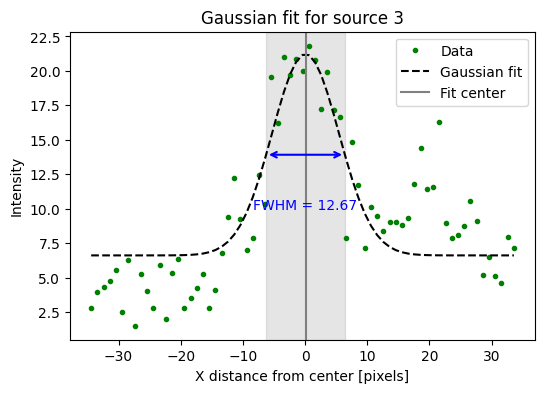

In [52]:
fit_params, ax = plot_xy_cut_gaussian(image_clean_bg, source, sourceID = 1, axis = 'y', factor = factor)
ax.set_title(f"Gaussian fit for source {3:d}")
amp, mu, sigma, offset = fit_params # mu 是中心, sigma 是標準差
fwhm_fit = sigma * 2.355
print("Fitted FWHM:", fwhm_fit)

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_9807/1896264763.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


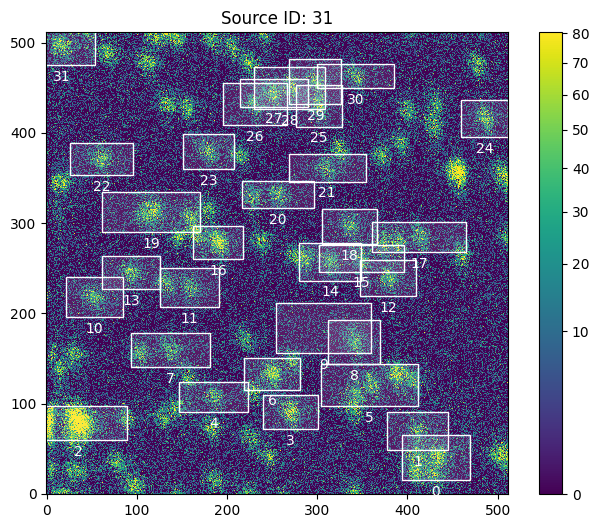

In [33]:
import matplotlib.patches as patches

source_id = 1
fig, ax = plot_picture(image_clean_bg, percent=98.5, title='Image_12.png', figsize=(8, 6))

for i in range(len(source)):
    source_id = i
    x0, y0, x_half_range, y_half_range = source[source_id]['xcentroid'], source[source_id]['ycentroid'], 2*source[source_id]['x_fwhm'], factor*source[source_id]['y_fwhm']
    rect = patches.Rectangle(
        (x0 - x_half_range, y0 - y_half_range),  # 左下角
        2*x_half_range,  # 寬
        2*y_half_range,  # 高
        linewidth=1,
        edgecolor=(1, 1, 1, 1), # white, alpha = 1
        facecolor= (1, 1, 1, 0.1) # white, alpha = 0.3
    )
    # add text label
    ax.text(x0, y0 - y_half_range - 5, f'{source_id}', color='white', fontsize=10, ha='center', va='top')
    ax.add_patch(rect)
    ax.set_title('Source ID: {}'.format(source_id))
    fig1.show()

Source 0: Fitted FWHM: 32.71835204499558
Source 1: Fitted FWHM: 7.492384693254715
Source 2: Fitted FWHM: 26.621255664363584
Source 3: Fitted FWHM: 16.664966226403845
Source 4: Fitted FWHM: 9.213640259475213
Source 5: Fitted FWHM: 37.60118190788965
Source 6: Fitted FWHM: 16.502818404755352
Source 7: Fitted FWHM: 12.704000227362364
Source 8: Fitted FWHM: 17.87987210587877
Source 9: Fitted FWHM: 31.626193497599022
Source 10: Fitted FWHM: 14.799404431559761
Source 11: Fitted FWHM: 17.6653847285503
Source 12: Fitted FWHM: 9.702886147332903
Source 13: Fitted FWHM: 14.407361910430103
Source 14: Fitted FWHM: 16.330679635047805
Source 15: Fitted FWHM: 18.68351125026632
Source 16: Fitted FWHM: 15.305011037647224
Source 17: Fitted FWHM: 20.27708346638116
Source 18: Fitted FWHM: 12.381389711921594
Source 19: Fitted FWHM: 20.9896787103228
Source 20: Fitted FWHM: 17.062570805512298
Source 21: Fitted FWHM: 10.196037422659723
Source 22: Fitted FWHM: 14.158734377180592
Source 23: Fitted FWHM: 17.459123

Text(0.5, 0.98, 'Gaussian Fits y for All Sources')

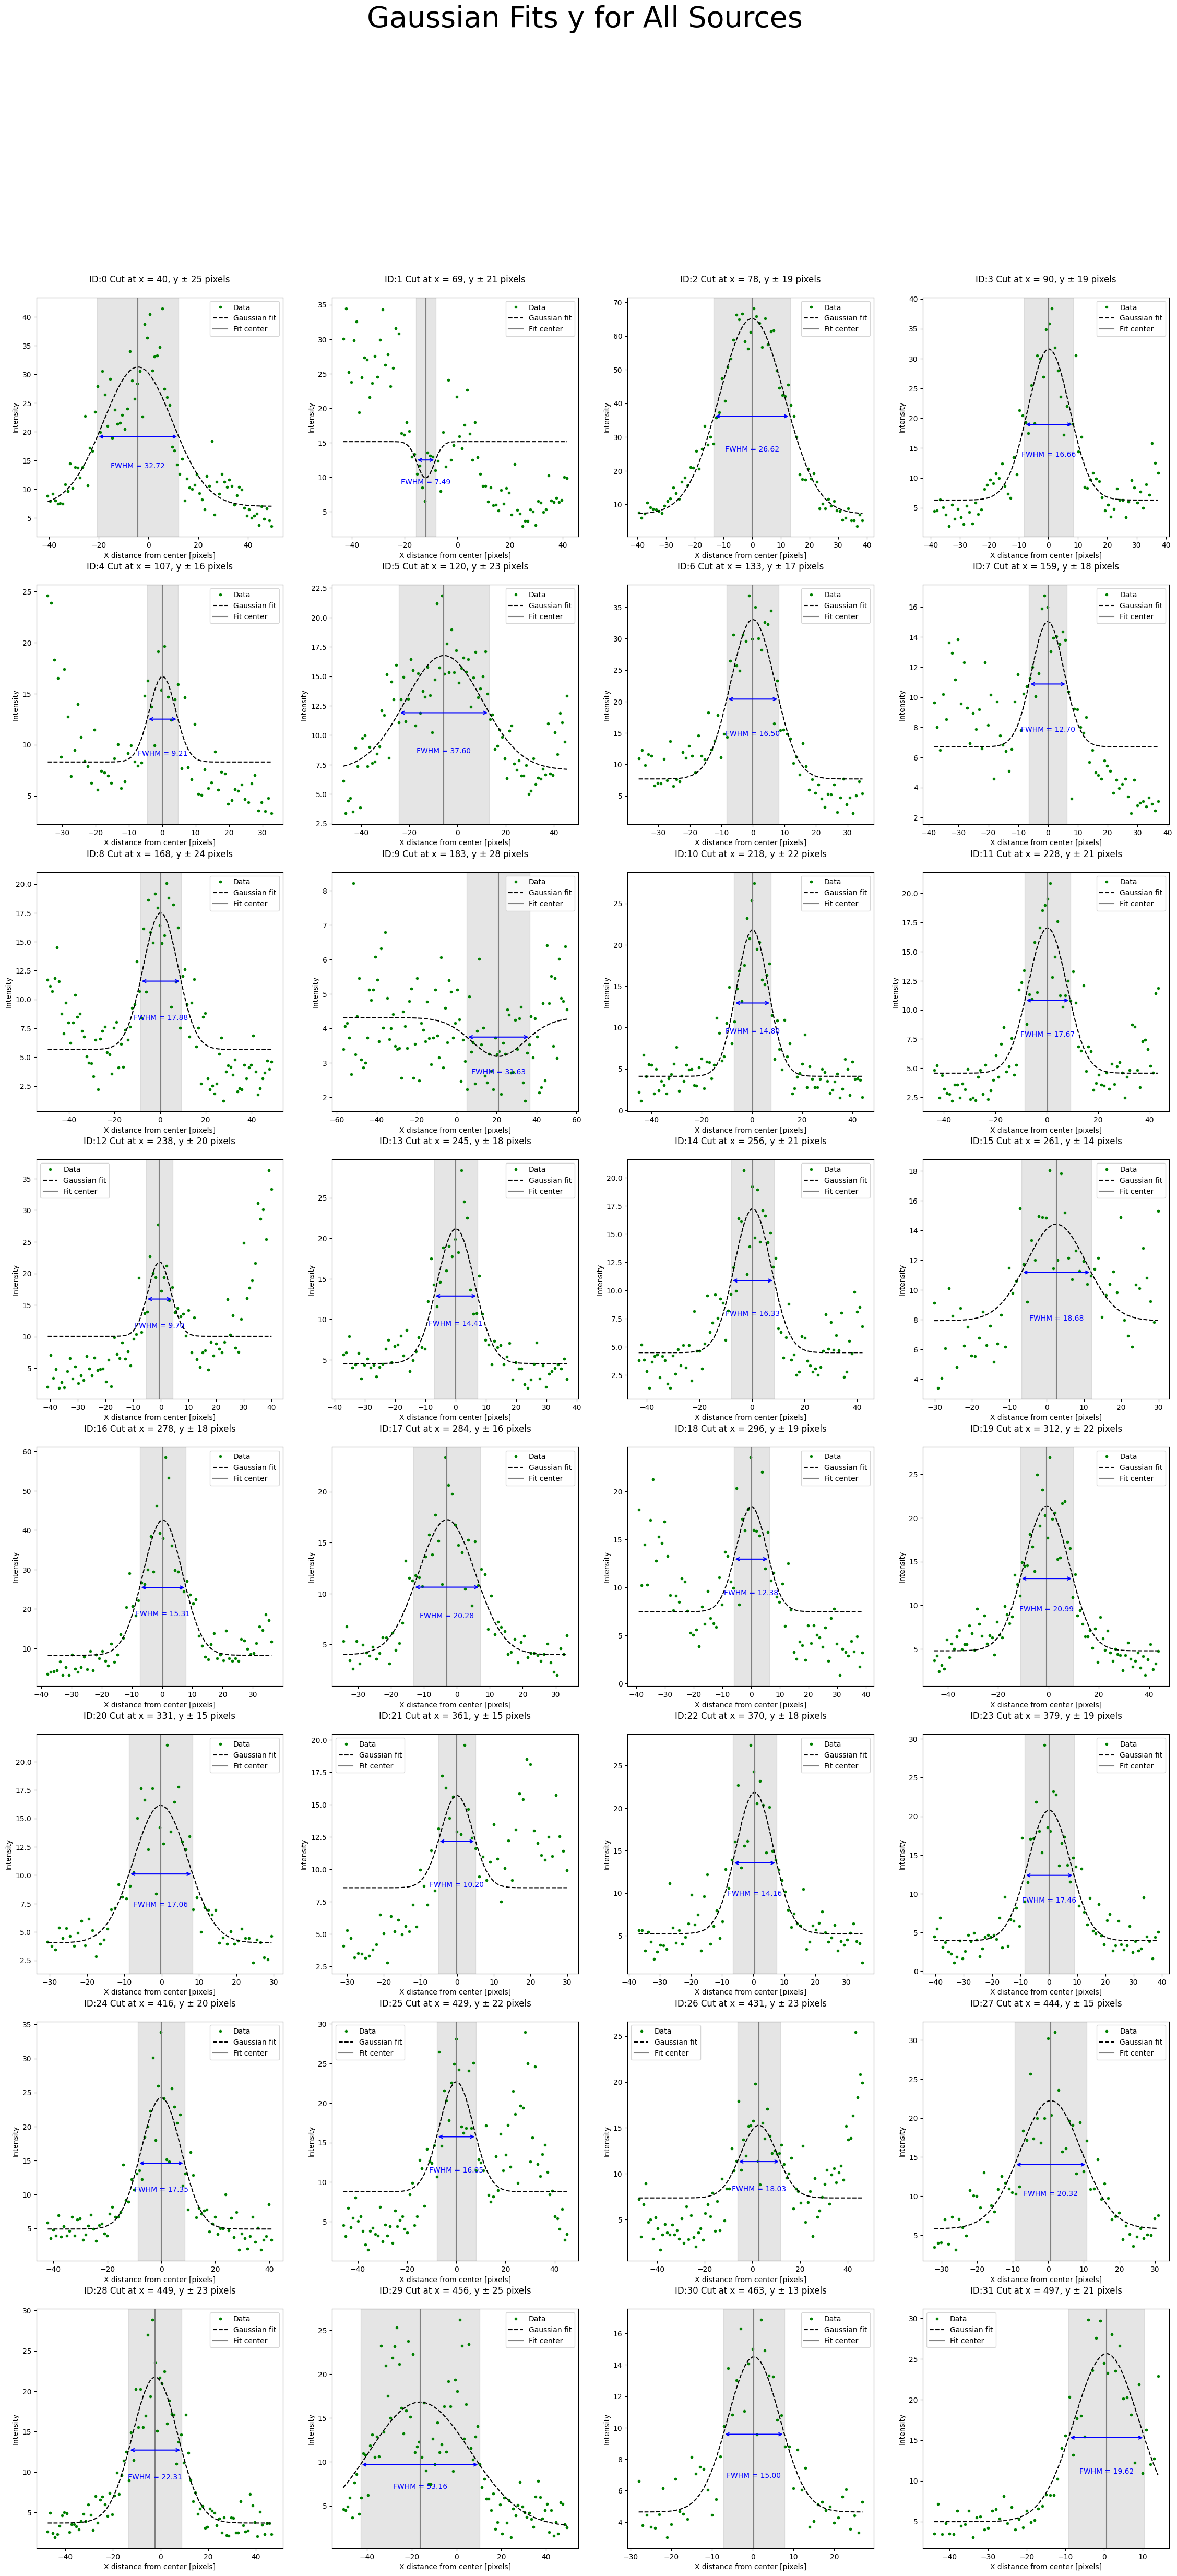

In [34]:
# for each source, plot the x cut gaussian fit and create subplots
num_sources = len(source)
axis = 'y'
num_cols = 4
num_rows = (num_sources + num_cols - 1) // num_cols  #
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*7, num_rows*7))
axes = axes.flatten()  # 將 2D 陣列展平為
for i in range(num_sources):
    fit_params, ax = plot_xy_cut_gaussian(image_clean_bg, source, sourceID = i, axis = axis, factor = factor, ax=axes[i])
    amp, mu, sigma, offset = fit_params # mu 是中心, sigma 是標準差
    fwhm_fit = sigma * 2.355
    print(f"Source {i}: Fitted FWHM: {fwhm_fit}")

fig.suptitle(f'Gaussian Fits {axis} for All Sources', fontsize=40)

    
